In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skfeature.function.similarity_based import fisher_score, lap_score
from skfeature.utility import construct_W

from sklearn.manifold import MDS, TSNE
from sklearn.preprocessing import StandardScaler

In [3]:
def tdaSelection(data,lens,r,is_min_best=True,equalize=True):
    data_scaled = StandardScaler().fit_transform(data)
    clusters = {}
    if equalize==True:
        score_ = score.sort_values()
        m = len(data.T)
        k = int(m/r)
        for i in np.arange(r):
            clusters[i] = list(score_.sort_values()[i*k:(i+1)*k].index)
        clusters[r-1] += list(score_.sort_values()[r*k:].index)
    else:
        bins = np.histogram(lens,bins=r)[1]
        bins[-1] = np.inf
        for i,f in zip(np.digitize(lens,bins),lens.index):
            if (i-1 not in clusters.keys()):
                clusters[i-1] = [f]
            else:
                clusters[i-1].append(f)
    dist = pd.DataFrame(np.arccos(abs(np.corrcoef(data_scaled.T))),index=data.columns,columns=data.columns)
    distmat = pd.DataFrame(np.zeros((len(clusters.keys()),len(clusters.keys()))),index=clusters.keys(),columns=clusters.keys())
    for i in np.arange(len(distmat)):
        for j in np.arange(i):
            distmat.iloc[i,j] = dist.loc[clusters[distmat.index[i]],clusters[distmat.index[j]]].min().min()
    distmat += distmat.T
            
    initial_cluster = max(clusters.keys()) if (is_min_best==True) else 0
    initial_feature = lens[clusters[initial_cluster]].idxmin() if (is_min_best==True) else lens[clusters[initial_cluster]].idxmax()
    
    used_clusters = [initial_cluster]
    selected_features = [initial_feature]
    
    for k in clusters.keys():
        if k==initial_cluster:
            continue
        else:
            new_cluster = distmat[used_clusters].min(axis=1).idxmax()
        used_clusters += [new_cluster]
        new_feature = lens[clusters[new_cluster]].idxmin() if (is_min_best==True) else lens[clusters[new_cluster]].idxmax()
        selected_features.append(new_feature)
        
    return selected_features,clusters,used_clusters

In [6]:
rawdata = pd.read_csv('pd_speech_features.csv',header=1)
rawdata.head()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1


In [18]:
data = rawdata.iloc[:,2:-1]
data.head()

,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,...,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36
0,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,0.00067,...,1.5466,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405
1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,0.000016,0.00052,...,1.5530,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780
2,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,0.000015,0.00057,...,1.5399,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666
3,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,0.000046,0.00149,...,6.9761,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603
4,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,0.000044,0.00166,...,7.8832,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164


In [32]:
data_scaled = StandardScaler().fit_transform(data)

In [33]:
kwargs_W = {'metric':'euclidean','neighbor_mod':'knn','weight_mode':'heat_kernel','k':5,'t':1}
W = construct_W.construct_W(data_scaled,**kwargs_W)
score = pd.Series(lap_score.lap_score(data_scaled,W=W),index=data.columns)

In [34]:
selected_features, clusters, used_clusters = tdaSelection(rawdata,score,50)

In [36]:
len(selected_features)

50

In [37]:
distmat = np.arccos(abs(np.corrcoef(data_scaled.T)))

In [38]:
mds_feature = MDS(dissimilarity='precomputed').fit_transform(distmat)

In [39]:
cluster_label = pd.Series(np.zeros(len(data.columns)),index=data.columns)
for k,v in clusters.items():
    cluster_label[v] = k
cluster_label /= cluster_label.max()

In [50]:
selected_label = pd.Series(np.zeros(len(data.columns)),index=data.columns)
for i,f in enumerate(selected_features[:30]):
    selected_label[f] = 1
selected_label = 1-selected_label

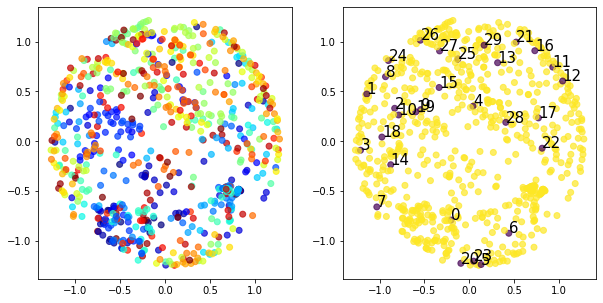

In [52]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].scatter(mds_feature[:,0],mds_feature[:,1],c=cluster_label,alpha=0.7,cmap=plt.cm.jet)
axes[1].scatter(mds_feature[:,0],mds_feature[:,1],c=selected_label,alpha=0.7)
for i,f in enumerate(selected_features[:30]):
    r = np.where(data.columns==f)[0]
    axes[1].text(mds_feature[r,0],mds_feature[r,1],i,fontsize=15)